# Analysis of RNASeq Data from Day 0 
In this notebook, I will be completing RNASeq analysis for the day 0 data. These efforts are part of Aim 1 for my BMEG490B paper, which is: 

<b> Characterizing T-Lineage Restriction of MLPs grown in LEM </b>

In this document, I will be reading in the created ReadCountdata, performing quality control, linking genes to one of three phenotypes of interest (CD45RA-CLEC12A-,CD45RA+CLEC12A- and CLEC12A+). 

## Experimental Workflow 

The experimental workflow generating this data comes from the work of Dr. Fangwu Wang and the Eaves lab, outlined in a paper titled "Human Lymphoid-Neutrophil/Monocyte Restriction Co-ordinately Activates Increased Proliferation Despite Parallel Heterogeneity In Transcriptional Changes". The paper can be found via this link: https://www.biorxiv.org/content/10.1101/2024.02.18.580894v1.full 


The experimental process used to generate the FastQ reads in this file are outlined in Figure 6 of the paper, titled "CD34+RA-C-cells in a lower proliferative state display higher self-renewal transcriptional programs when stimulated to differentiate". 

## Information about the Cells in this Analysis
In this analysis, we will be processing cells obtained at Day 0. Specifically, we are looking at primary cord blood cells that are enriched for CD34+ expression, that were chosen given their strong output in lymphoid progenitors. These cells were dubbed `P-Mix` cells, short for progenitor-mix cells. 

On Day0, a cryopreserved aliquot of these progwas thawed. Cells were then resuspended in PBS supplemented with 1% FBS and 9.1% TruStain FcX. Following a 10-minute incubation, cells were stained with both flow cytometry antibodies and TotalSeq antibodies (BioLegend) as follows: TotalSeq-B0853 anti-human CD371 (CLEC12A), TotalSeq-B0063 anti-human CD45RA, TotalSeq-B0062 anti-human CD10, TotalSeq-B0066 anti-human CD7, TotalSeq-B0054 anti-human CD34, TotalSeq-B0051 anti-human CD14, TotalSeq-B0392 anti-human CD15 (SSEA-1), CD45-AF700 (HI30, BioLegend), CD71-FITC (OKT9, eBioscience), CD38-PECY7 (HIT2, BioLegend), CD45RA-APC (MEM56, Invitrogen), CLEC12A-PE (HB3, eBioscience), CD10-BB700 (MEM78, BD Biosciences) and CD34-BV421 (561, BioLegend).

 Gene expression and surface protein libraries were generated using the Chromium Next GEM Single Cell 3 ’Reagent Kits v3.1 and sequenced by Illumina MiSeq or NextSeq2000. 

## Prior Work Done 

 Prior to the implementation of the analysis in this notebook, the generated BCL files were converted into demultiplexed FASTQ files, which were then processed using Cell Ranger Count v8.0.1 (10x Genomics). Alignment of reads to the human reference genome GRCh38 and calculation of Unique Molecular Identifier (UMI) counts for gene expression and antibody libraries were performed on CellRanger Cloud, and completed using the "Cell Ranger Count" commaand. The UMI counts mapped to each cell were then compiled into a feature-barcode matrix.

 With this context, we can begin our analysis!

 # Step 1: Pre-processing

 In this section, we are going to pre-process the data to create the `SingleCellExperiment` object within the BioConductor analysis pipeline. I will be following the pipeline defined in the free e-book "Orchestrating Single-Cell Analysis" by CellRanger, which may be obtained here: https://bioconductor.org/books/release/OSCA/

 This step will consist of the following phases: 

 1. Analysis of CellRanger Outputs 
 2. Creation of the SingleCellExperriment Object 
 3. Quality Control of scRNASeq Library


 ## 1.1 - Analysis of CellRanger Outputs

In [ ]:
# Analysis of CellRanger Outputs



## 1.2 - Creation of SingleCellExperiment Object

In [2]:
# Creation of SingleCellExperiment Object
library(DropletUtils)
sce <- read10xCounts("data/filteredOutput")
sce


class: SingleCellExperiment 
dim: 36608 4731 
metadata(1): Samples
assays(1): counts
rownames(36608): ENSG00000243485 ENSG00000237613 ... TOTALSEQB_CD14
  TOTALSEQB_CD15
rowData names(3): ID Symbol Type
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

Nice! It looks like I was able to generate the SCE object by pointing to the directory containing the contents of the filtered feature matrix, and have now created a SingleCellExperiment Class object. 

What does this object hold? Simply put, this object class implements a data structure that sttores all aspects of our single-cell data, gene-by-cell expression data, per-cell metadata and per-gene annotation. This allows for us to manipulate them in a synchronized manner. 

Each piece of metadata in the `SingleCellExperiment` class is represented by a "slot". If you imagine the `SingleCellExperiment` object to be a cargo ship, the slots can be thought of as individual cargo boxes with different contents - eg. certain slots expect numeric matrieces whereas other expect dataframes.  

![SCEDescriptor](img\SingleCellExperiment.png)

The `assays` metadata is the most important here, since it contains the primary data such as matrix of sequecing counts, where rows correspond to features (genes), and columns correspond to samples (cells). 

Lets take a look at what's inside the `counts` slot of the  `sce` object we just created

In [ ]:
counts(sce)


36608 x 4731 sparse Matrix of class "dgCMatrix"
                                                                                            
ENSG00000243485  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000237613  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000186092  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000238009  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000239945  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000239906  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000241860  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  1  .
ENSG00000241599  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000286448  .  .  .  .  .  .   .  .  .  .  .  .  .  .  .  .  .   .  .  .  .  .  .  .  .
ENSG00000236601  .  . 

Nice! We see that the `assay`  is holding two types of information - the count matrix, and the antibody data, in the form of a spare matrix. This may be confusing, so lets split them into two different slots. 

In [ ]:
split_sce <- splitAltExps(sce, rowData(sce)$Type)
split_sce


class: SingleCellExperiment 
dim: 36601 4731 
metadata(1): Samples
assays(1): counts
rownames(36601): ENSG00000243485 ENSG00000237613 ... ENSG00000278817
  ENSG00000277196
rowData names(3): ID Symbol Type
colnames: NULL
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: Gene Expression
altExpNames(1): Antibody Capture

Nice! We see that we have seperated the Antibody data into an alternate experiment. We could store this as a seperate assay, or keep it seperated as an alternate experiment!

The last thing I am going to touch on is the metadata of a `SingleCellExperiment`.  To begin, we can further annotate the metadta of the columns of our primary data by using the `colData` slot. This is a `DataFrame` object where rows correspond to cells and columns correspond to metadata fields (e.g. batch of origin, treatment condition, etc.). We can manually access this information with the `colData()` function. 

Simmiliarly, we can store feature level annotation in the `rowData` slot of a `DataFrame`, where each row corresponds to a gene and contains annotations like the transcript length or gene symbol. We can manually get this with the `rowData()` function. 

In [5]:
rowData(split_sce)


DataFrame with 36601 rows and 3 columns
                             ID      Symbol            Type
                    <character> <character>     <character>
ENSG00000243485 ENSG00000243485 MIR1302-2HG Gene Expression
ENSG00000237613 ENSG00000237613     FAM138A Gene Expression
ENSG00000186092 ENSG00000186092       OR4F5 Gene Expression
ENSG00000238009 ENSG00000238009  AL627309.1 Gene Expression
ENSG00000239945 ENSG00000239945  AL627309.3 Gene Expression
...                         ...         ...             ...
ENSG00000277836 ENSG00000277836  AC141272.1 Gene Expression
ENSG00000278633 ENSG00000278633  AC023491.2 Gene Expression
ENSG00000276017 ENSG00000276017  AC007325.1 Gene Expression
ENSG00000278817 ENSG00000278817  AC007325.4 Gene Expression
ENSG00000277196 ENSG00000277196  AC007325.2 Gene Expression

In [6]:
colData(split_sce)


DataFrame with 4731 rows and 2 columns
                  Sample            Barcode
             <character>        <character>
1    data/filteredOutput AAACCCACAGATCACT-1
2    data/filteredOutput AAACCCAGTCCAGCAC-1
3    data/filteredOutput AAACCCAGTGTATACC-1
4    data/filteredOutput AAACCCATCTCTCTAA-1
5    data/filteredOutput AAACGAAAGATCGACG-1
...                  ...                ...
4727 data/filteredOutput TTTGGAGTCGGTGCAC-1
4728 data/filteredOutput TTTGGTTTCACTCACC-1
4729 data/filteredOutput TTTGGTTTCATAGGCT-1
4730 data/filteredOutput TTTGGTTTCCGCGAGT-1
4731 data/filteredOutput TTTGTTGCACACTTAG-1

## 1.3 - Quality Control Steps 

### Motivation for Quality Control 

Low quality libraries in scRNA-seq data can arise form a variety of sources such as cell damage during dissociation or failure in library preperation (ineffecient reverse transcription or PCR Amplification, for example). These artifacts usually manifest as "cells" with low total counts, few expressed genes, or high mitochondrial or spike in proportions. 

These low-quality libraries are problematic, as they can contribute to misleading results in downstream analyses. Some common effects are: 

- The form their own distinct clusters, complicating the interpretation of results. This is mainly driven by the increased mitochondrial proportions or enrichment for nuclear RNAs after cell damage. 
- They interefere with the chaatacterization of population heterogeneity during variance estimation or PCA. Specifically, during dimensionality reduction, the first few steps will end up capturing the difference in quality rather than biology, reducing the effectiveness of dimensionality reduction. Similiarly, genes with the largest variances will be driven by differences between low and high quality cells. 
- They contain genes that appear strongly "upregulated" due to agressive scaling to normalize for small library sizes. This is most problematic for contaminating transcripts (eg, from ambient solution) that are present in all libraries, but at transient levels. 

To avoid/mitigate these issues, we need to remove the problematic cells at the tsrta of the analysis. This step is commonly referred to as quality control (QC) of cells. 

### Common QC Metrics 

Some of the metrics we can use to identify low quality cells are: 

- **The library size:** The library size is defined as the total sum of counts across all relevant features for each cell (a cells total gene count, if you will).  Cells with small library sizes are of low quality, as the RNA has been lost at some point during the libraryr preperation, either due to cell lysis or inefficient cDNA capture. 
- **Number of expressed features:** Defined as the number of endogenous genes with non-0 counts for that cell. Any cell with very few expressed genes is likely to be of poor quality as the diverse transcript population has not been captured. 
- **The proportion of reads mapped to spike-in transcripts:** As the same amount of spike in RNA should have been added to each cell, any enrichment in spike-in count is sumptomatic of loss of endogenous RNA. Therefore, high proportions are indicative of poor quality cells where endogenous RNA has been lost due to partial cell lysis or RNA degradation. 
- **Proportion of reads mapped to mitochondrial genome:** High proportions are indicative of poor quality cells, because of the loss of cytoplasmic RNA from perforated cells. This reasoning is that, in the prosence of modest damage, the holes in the cell memebrane permit efflux of indicidual ttrnascript molecules, but are too small to allow mitochondria to escape, leading to a relative enrichment of mitochondrial transcripts. 

### Implementing QC 

In this analysis, we will calculate the QC metrics using the `perCellQCMetrics()` fucntion fromthe *scater* package. The `sum` column contains the total count for each cell, and the `detected` column contains the number of detected genes. The `subsets_Mito_percent` column contains the percentage of reads mapped to mitochondrial transcripts, and finally the `altexps_ERCC_percent` column contains the percentage of reads mapped to ERCC transcripts. 

Lets begin by identifying the mitochondrial transcripts in our SingleCellExperiment: 

In [7]:
# Identifying mitochondrial transcripts

mito <- grep("^MT-", rowData(split_sce)$Symbol)

library(scuttle)

mito_qc <- perCellQCMetrics(split_sce, subsets = list(Mito = mito))

head(mito_qc)


DataFrame with 6 rows and 9 columns
        sum  detected subsets_Mito_sum subsets_Mito_detected
  <numeric> <integer>        <numeric>             <integer>
1     11666      3554              409                    12
2     10112      3654              295                    11
3     14041      4153              520                    12
4     12291      3475              639                    12
5      9770      3299              299                    12
6     12207      3398              539                    12
  subsets_Mito_percent altexps_Antibody Capture_sum
             <numeric>                    <numeric>
1              3.50591                          903
2              2.91733                         2326
3              3.70344                         1991
4              5.19893                         1284
5              3.06039                         2200
6              4.41550                         1095
  altexps_Antibody Capture_detected altexps_Antibody Capture

Nice! We have obtained a dataframe containing calculations for all of our metrics, from both the antibody and gene ensemble parts of our dataset. Next, lets use this to make a decision on if we will be keeping or rejecting certain genes: 

In [8]:
mito_decisions <- perCellQCFilters(mito_qc, sub.fields = c("subsets_Mito_percent"))

head(mito_decisions)


DataFrame with 6 rows and 4 columns
      low_lib_size   low_n_features high_subsets_Mito_percent   discard
  <outlier.filter> <outlier.filter>          <outlier.filter> <logical>
1            FALSE            FALSE                     FALSE     FALSE
2            FALSE            FALSE                     FALSE     FALSE
3            FALSE            FALSE                     FALSE     FALSE
4            FALSE            FALSE                     FALSE     FALSE
5            FALSE            FALSE                     FALSE     FALSE
6            FALSE            FALSE                     FALSE     FALSE

Nice! Lets see how many cells we will be discarding based on mitochondrial percentage: 

In [ ]:
discard.GE <- mito_decisions$discard

sum(discard.GE == TRUE)
sum(discard.GE == FALSE)

# Adding this information to the metadata of SingleCellExperiment Object
colData(split_sce) <- cbind(colData(split_sce), mito_qc)

split_sce$discard.GE <- discard.GE


[1] 384

[1] 4347

From the complete gene set, we see that 384 will be rejected, while 4347 will be retained. Lets take a look at these discarded cells. 

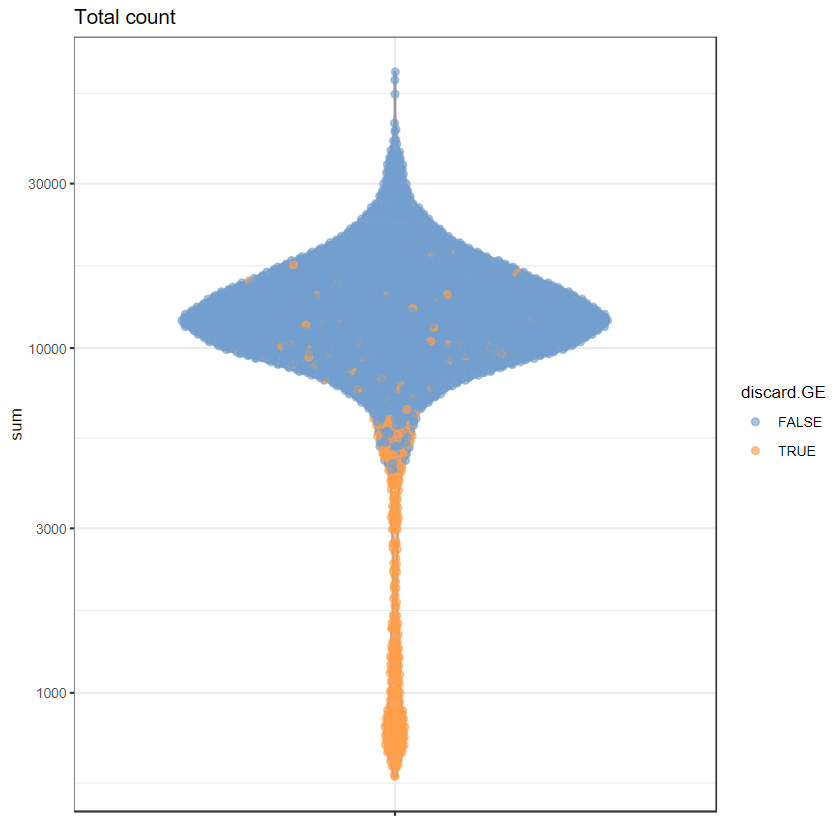

Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message in scale_y_log10():
"log-10 transformation introduced infinite values."
Warning message:
"Removed 2 rows containing non-finite outside the scale range
(`stat_ydensity()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."


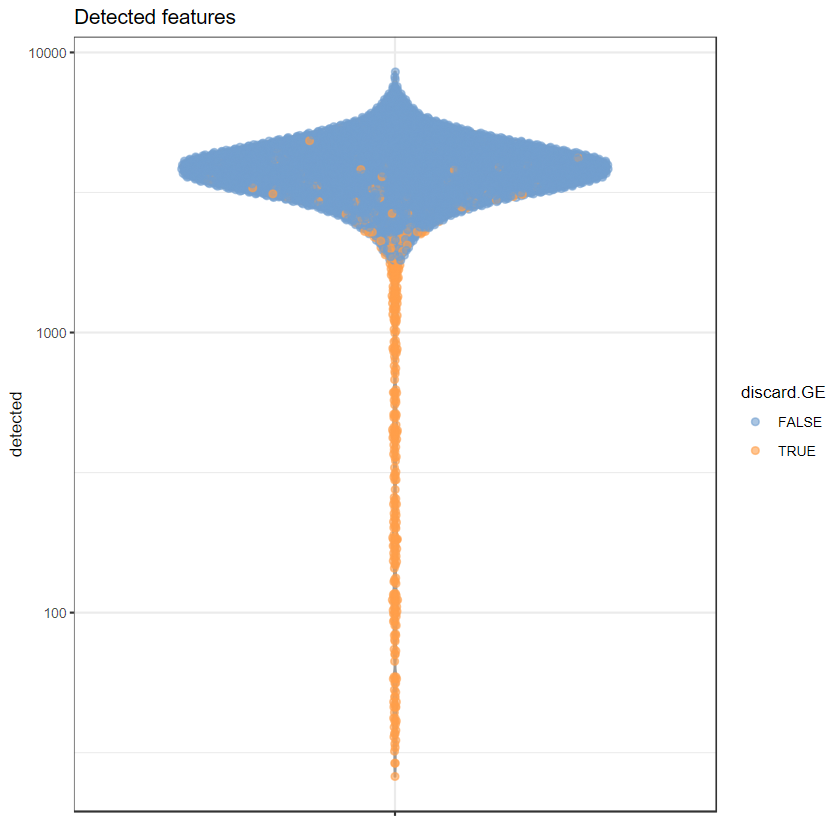

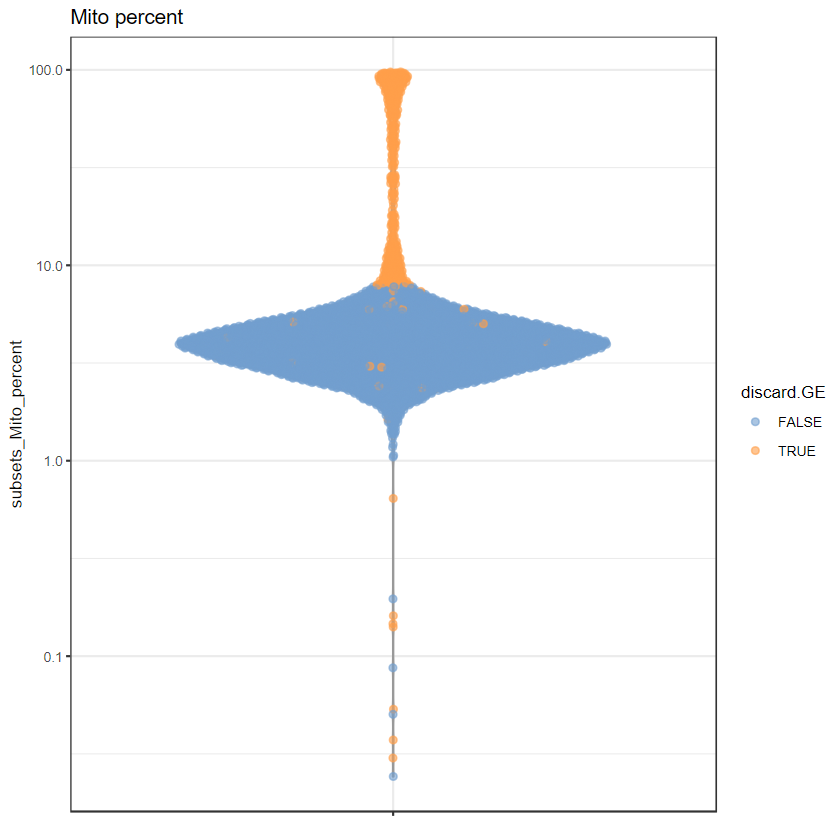

In [ ]:
library(scater)

# total UMI
plotColData(split_sce, y = "sum", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Total count") # nolint: line_length_linter.

# detected genes
plotColData(split_sce, y = "detected", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Detected features") # nolint: line_length_linter.

# mito percent
plotColData(split_sce, y = "subsets_Mito_percent", colour_by = "discard.GE") + scale_y_log10() + ggtitle("Mito percent") # nolint: line_length_linter.


It appears that the cells we are discarding are truly outliers. Sanity check passed! Lets continue now onto doing similiar QC for our antibody dataset. 

In [ ]:
controls <- grep("^T", rownames(altExp(split_sce)))
antibody_qc <- cleanTagCounts(altExp(split_sce), controls = controls)

print(summary(antibody_qc$zero.ambient))


   Mode   FALSE    TRUE 
logical    4606     125 


Nice! Looks like we will be rejecting 125 samples based on Antibody corruption. Lets label our `SingleCellExperiment` object based on that, and then visualize to see where these cells are found. 

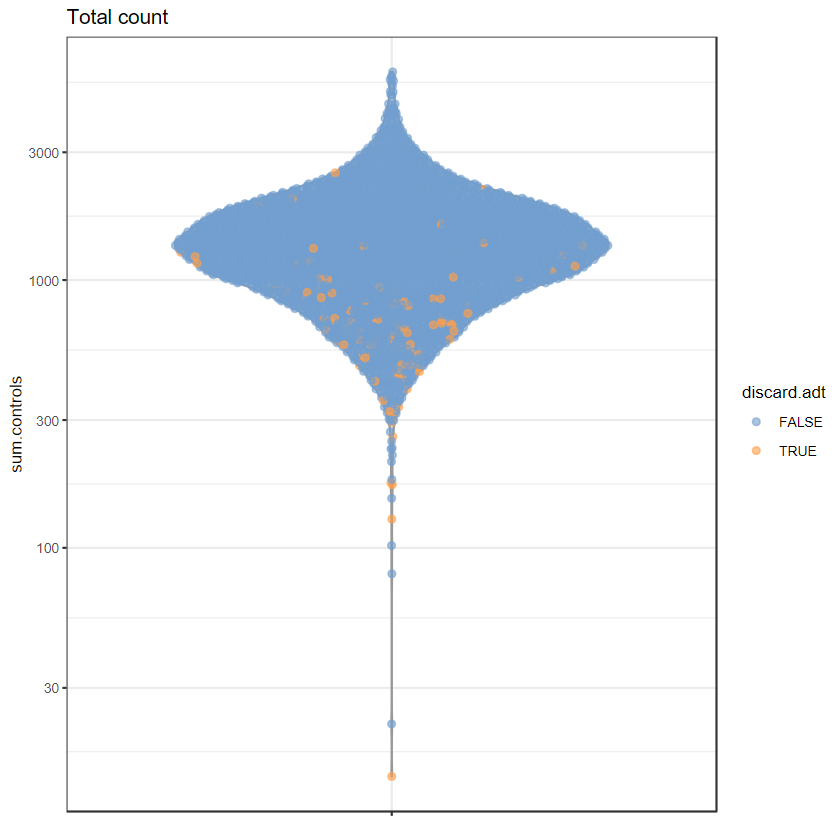

In [ ]:
colData(altExp(split_sce)) <- cbind(colData(altExp(split_sce)), antibody_qc)

discard.adt <- antibody_qc$zero.ambient # use zero ambient as the only criteria

altExp(split_sce)$discard.adt <- discard.adt

plotColData(altExp(split_sce), y = "sum.controls", colour_by = "discard.adt") + scale_y_log10() + ggtitle("Total count") # nolint


Okay, it looks like we will be tossing some usefull cells here, but its not the end of the world. Lets now remove all the cells we have marked from the discard dataset, as 